**Loading the Data**

We start by loading both the news data (from the CSV file gnews_indian_stock_market_250_days_incremental.csv) and the Nifty 50 market data (from nifty50.csv).

In [1]:
import pandas as pd
import nltk

# Load the necessary datasets
df_news = pd.read_csv('gnews_indian_stock_market_250_days_incremental.csv')
df_market = pd.read_csv('nifty50.csv')

# Download NLTK data (if needed)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Check the first few rows of both datasets
print(df_news.head())
print(df_market.head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


                            Date  \
0  Wed, 09 Oct 2024 14:04:28 GMT   
1  Wed, 09 Oct 2024 17:16:19 GMT   
2  Fri, 04 Oct 2024 10:19:56 GMT   
3  Wed, 09 Oct 2024 14:24:04 GMT   
4  Thu, 03 Oct 2024 07:41:47 GMT   

                                               Title          Source  \
0  India Stock Market Outlook: October 2024 - Forbes  Unknown Source   
1  Latest Market News Today highlights October 9,...  Unknown Source   
2  Indian shares post worst week in over 2 years ...  Unknown Source   
3  Stock Market Highlights: Nifty faces resistanc...  Unknown Source   
4  Why India’s Giant Options Market Poses a Dange...  Unknown Source   

                                                 URL  
0  https://news.google.com/rss/articles/CBMic0FVX...  
1  https://news.google.com/rss/articles/CBMiogFBV...  
2  https://news.google.com/rss/articles/CBMingFBV...  
3  https://news.google.com/rss/articles/CBMi1gFBV...  
4  https://news.google.com/rss/articles/CBMiuwFBV...  
       Date      Ope

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


**Preprocessing the News Headlines**

This step includes cleaning the text (lowercasing, removing punctuation, stopwords, etc.) and preparing it for sentiment analysis.

In [2]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function for news headlines
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply the preprocessing to the 'Title' column
df_news['Clean_Headline'] = df_news['Title'].apply(preprocess_text)

# Check the cleaned headlines
print(df_news[['Title', 'Clean_Headline']].head())


                                               Title  \
0  India Stock Market Outlook: October 2024 - Forbes   
1  Latest Market News Today highlights October 9,...   
2  Indian shares post worst week in over 2 years ...   
3  Stock Market Highlights: Nifty faces resistanc...   
4  Why India’s Giant Options Market Poses a Dange...   

                                      Clean_Headline  
0          india stock market outlook october forbes  
1  latest market news today highlight october oil...  
2  indian share post worst week year mideast fear...  
3  stock market highlight nifty face resistance s...  
4  india giant option market pose danger financia...  


**Perform Sentiment Analysis**

We use TextBlob to calculate sentiment polarity for each cleaned headline, and then classify the sentiment as positive, neutral, or negative.

In [3]:
from textblob import TextBlob

# Function to calculate sentiment score
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis
df_news['Sentiment_Score'] = df_news['Clean_Headline'].apply(get_sentiment)

# Classify sentiment based on the score
def classify_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Negative'

df_news['Sentiment'] = df_news['Sentiment_Score'].apply(classify_sentiment)

# Check the sentiment data
print(df_news[['Clean_Headline', 'Sentiment_Score', 'Sentiment']].head())


                                      Clean_Headline  Sentiment_Score  \
0          india stock market outlook october forbes         0.000000   
1  latest market news today highlight october oil...        -0.100000   
2  indian share post worst week year mideast fear...        -0.562500   
3  stock market highlight nifty face resistance s...         0.213636   
4  india giant option market pose danger financia...         0.000000   

  Sentiment  
0   Neutral  
1  Negative  
2  Negative  
3  Positive  
4   Neutral  


**Preprocess Nifty Market Data**

We clean and prepare the Nifty 50 market data by calculating the daily market return and formatting the Date column.

In [4]:
# Clean the market data and calculate daily returns
df_market.columns = df_market.columns.str.strip()  # Remove whitespace from columns
df_market['Date'] = pd.to_datetime(df_market['Date'])  # Convert to datetime
df_market['Market_Return'] = df_market['Close'].pct_change()  # Calculate daily returns

# Keep necessary columns
df_market = df_market[['Date', 'Close', 'Market_Return']]

# Check the market data
print(df_market.head())


        Date     Close  Market_Return
0 2024-07-10  24324.45            NaN
1 2024-07-11  24315.95      -0.000349
2 2024-07-12  24502.15       0.007658
3 2024-07-15  24586.70       0.003451
4 2024-07-16  24613.00       0.001070


<ipython-input-4-b5cc0cca50c4>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_market['Date'] = pd.to_datetime(df_market['Date'])  # Convert to datetime


**Merge the News and Market Data**

We ensure both datasets use the same format for the Date column, then merge them based on the date.

In [5]:
# Convert both 'Date' columns to the same format (remove timezone info)
df_news['Date'] = pd.to_datetime(df_news['Date']).dt.date
df_market['Date'] = pd.to_datetime(df_market['Date']).dt.date

# Merge news sentiment data with Nifty market data on 'Date'
df_merged = pd.merge(df_news.groupby('Date')['Sentiment_Score'].mean().reset_index(),
                     df_market, on='Date', how='inner')

# Check the merged data
print(df_merged.head())


         Date  Sentiment_Score     Close  Market_Return
0  2024-07-11             0.08  24315.95      -0.000349
1  2024-07-23             0.00  24479.05      -0.001232
2  2024-08-05             0.00  24055.60      -0.026786
3  2024-08-06             0.00  23992.55      -0.002621
4  2024-08-13             0.00  24139.00      -0.008543


**Calculate Correlation**

Now, we calculate the correlation between daily sentiment scores and Nifty market returns.

In [6]:
# Calculate correlation between daily sentiment scores and Nifty market returns
correlation = df_merged['Sentiment_Score'].corr(df_merged['Market_Return'])

# Display the correlation value
print(f'Correlation between Sentiment Score and Market Return: {correlation}')


Correlation between Sentiment Score and Market Return: 0.04008640762949374


**Visualization**

We visualize the relationship between the sentiment scores and market returns using a regression plot.

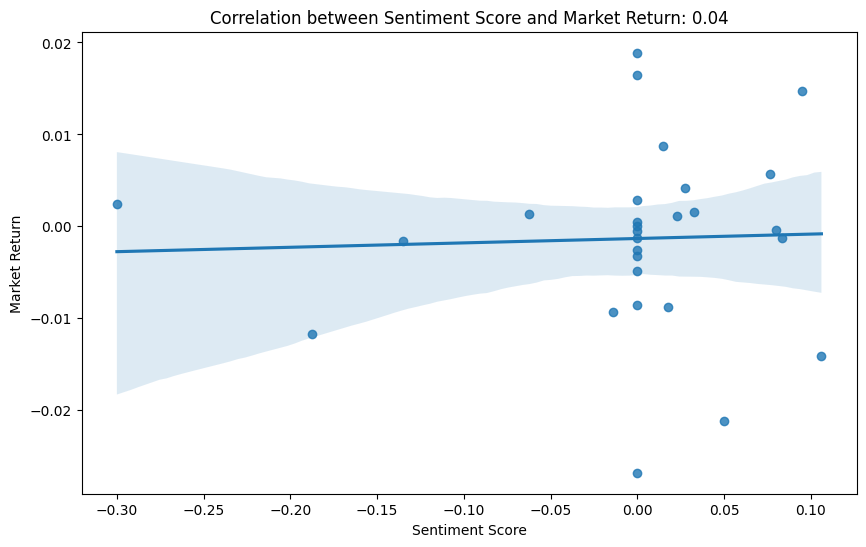

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the correlation between sentiment score and market return
plt.figure(figsize=(10, 6))
sns.regplot(x='Sentiment_Score', y='Market_Return', data=df_merged)
plt.title(f'Correlation between Sentiment Score and Market Return: {correlation:.2f}')
plt.xlabel('Sentiment Score')
plt.ylabel('Market Return')
plt.show()


<i>The correlation between the sentiment score and Nifty market returns is approximately 0.04, which indicates a very weak positive correlation. This suggests that the daily sentiment score from the news headlines has minimal influence on the daily returns of the Nifty 50 index during the given period.

The visualization shows the relationship between the sentiment scores and market returns, though the low correlation indicates there is little linear association between the two. </i>